# Coding With Me: Tensorflow
## Step 1: Hello World
<img src="./hello.PNG" alt="Hello TensorFlow!" width="200">
Let's validate the environment by the above "hello" graph:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import input_data

In [2]:
import tensorflow as tf
words = tf.constant('Hello, TensorFlow')
feel = tf.constant('!')
hello = tf.add(words, feel)
sess = tf.Session()
writer = tf.train.SummaryWriter("/root/compute/log/hello")
writer.add_graph(sess.graph)
print(sess.run(hello))
print(sess.run(feel))

Hello, TensorFlow!
!


## Step 2: Getting familar, a simple linear model

In TensorFlow, data models (e.g. CNNs)/loss functions (e.g. square loss)/optimizations (e.g. SGD) are converted to graphs, by which the computation is performed. The general steps are as following:
* Construct the model and draw the graph;
* Implement the graph in TensorFlow;
* Init variables and run/evaluate the graph in the TensorFlow session;
* (Optional) Display the graph in TensorBoard.

Let's mock some data from a linear model:
$y = 2.1x + 0.1$

In [3]:
x = np.random.rand(100, 1).astype("float32")
y = 2.1 *  x + 0.1

Let's add some Guassian noise and plot:

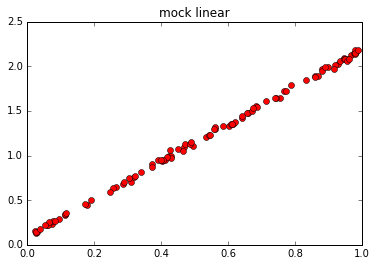

In [4]:
noise = np.random.normal(0, 0.02, (100, 1))
y = y + noise
plt.plot(x, y, 'ro')
plt.title("mock linear")

Construct the model:

In [5]:
x_ = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])
w = tf.Variable(tf.zeros([1,1]))
b = tf.Variable(tf.zeros([1,1]))
predict = x_ * w + b

Define loss function (mean square) and optimize:

In [6]:
loss = tf.reduce_mean(tf.square(y_ - predict))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

Run the graph, training for $w$ and $b$:
<img src="./linear.PNG" alt="A Simple Linear Model" width="200">

In [7]:
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
writer = tf.train.SummaryWriter("/root/compute/log/linear")
writer.add_graph(sess.graph)

for i in range(501):
    sess.run(train, feed_dict={x_: x, y_: y})
    if i % 50 == 0:
        print i, sess.run(w), sess.run(b)

0 [[ 0.84461546]] [[ 1.2190522]]
50 [[ 2.05569839]] [[ 0.12061879]]
100 [[ 2.09195042]] [[ 0.09975556]]
150 [[ 2.09289956]] [[ 0.09920931]]
200 [[ 2.09292412]] [[ 0.09919516]]
250 [[ 2.09292412]] [[ 0.09919516]]
300 [[ 2.09292412]] [[ 0.09919516]]
350 [[ 2.09292412]] [[ 0.09919516]]
400 [[ 2.09292412]] [[ 0.09919516]]
450 [[ 2.09292412]] [[ 0.09919516]]
500 [[ 2.09292412]] [[ 0.09919516]]


## Step 3: Working on MNIST

### Direct Softmax

### CNN